Text(0.5, 0, 'BloodPressure')

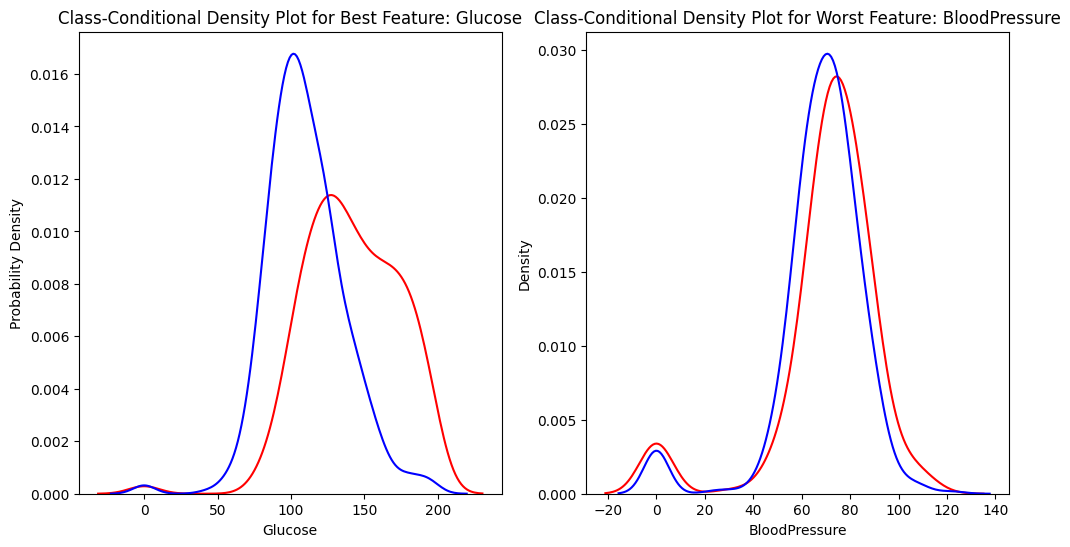

In [12]:
import arff, pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt
from sklearn import tree, metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif, mutual_info_classif

dataset = arff.load(open("diabetes.arff", "r"))
attribute_names = [attr[0] for attr in dataset['attributes']]
data_dict = {attr: [] for attr in attribute_names}

for row in dataset['data']:
    for i, value in enumerate(row):
        data_dict[attribute_names[i]].append(value)

df = pd.DataFrame(data_dict)

# 1
X, y = df.drop('Outcome', axis=1), df['Outcome']

f_values, p_values = f_classif(X, y)

feature_scores = pd.DataFrame({
    'Feature': X.columns,
    'F-Value': f_values,
    'p-Value': p_values
})

feature_scores = feature_scores.sort_values(by='F-Value', ascending=False)
best_feature = feature_scores.iloc[0]['Feature']
worst_feature = feature_scores.iloc[-1]['Feature']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.kdeplot(df[best_feature][df['Outcome'] == '1'], label='Diabetes', color='r')
sns.kdeplot(df[best_feature][df['Outcome'] == '0'], label='Normal', color='b')
plt.title(f'Class-Conditional Density Plot for Best Feature: {best_feature}')
plt.xlabel(best_feature)
plt.ylabel('Probability Density')
plt.subplot(1, 2, 2)
sns.kdeplot(df[worst_feature][df['Outcome'] == '1'], label='Diabetes', color='r')
sns.kdeplot(df[worst_feature][df['Outcome'] == '0'], label='Normal', color='b')
plt.title(f'Class-Conditional Density Plot for Worst Feature: {worst_feature}')
plt.xlabel(worst_feature)


Train accuracies:  [0.9934853420195437, 0.972312703583062, 0.9397394136807817, 0.8843648208469055, 0.8485342019543974, 0.8403908794788274, 0.7850162866449512] 
Test accuracies:  [0.7207792207792207, 0.7272727272727273, 0.7142857142857143, 0.7337662337662338, 0.7662337662337662, 0.7597402597402596, 0.7467532467532468]


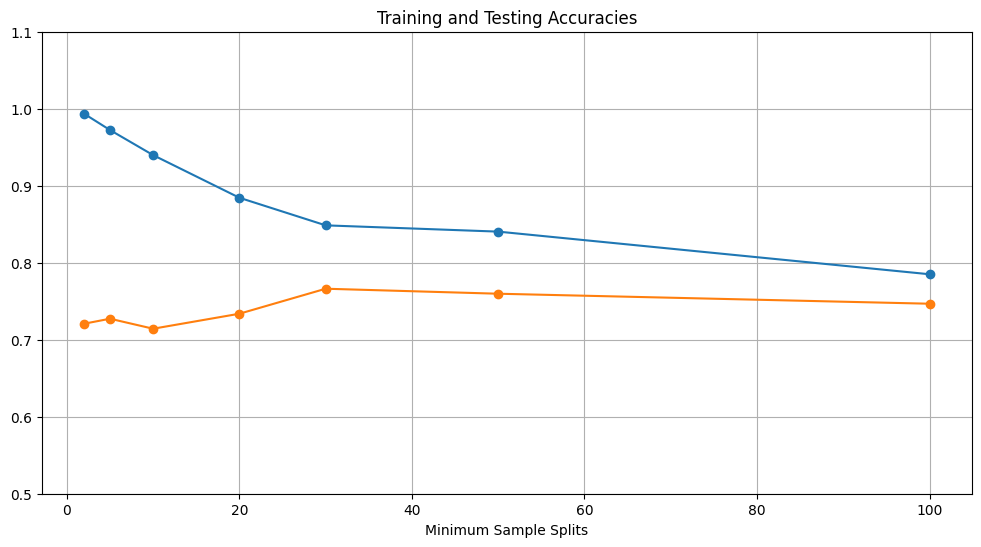

In [13]:
# 2
min_samples_split_values = [2, 5, 10, 20, 30, 50, 100]
n_runs, random_state = 10, 1
train_accuracies, test_accuracies = [], []

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state=random_state)

feature_scores = mutual_info_classif(X_train, y_train)
sorted_features = np.argsort(feature_scores)

for m in min_samples_split_values:

    train_m_acc, test_m_acc = [], []
    predictor = tree.DecisionTreeClassifier(min_samples_split=m, random_state=random_state)

    for _ in range(n_runs):
        top_features = sorted_features[-m:]
        X_m_train, X_m_test = X_train.iloc[:, top_features], X_test.iloc[:, top_features]

        predictor.fit(X_m_train, y_train)
        train_m_acc.append(metrics.accuracy_score(y_train, predictor.predict(X_m_train)))
        test_m_acc.append(metrics.accuracy_score(y_test, predictor.predict(X_m_test)))
    
    train_accuracies.append(np.mean(train_m_acc))
    test_accuracies.append(np.mean(test_m_acc))

print("Train accuracies: ", train_accuracies, "\nTest accuracies: ", test_accuracies)

plt.figure(figsize=(12, 6))
plt.plot(min_samples_split_values, train_accuracies, label='Training Accuracy', marker='o')
plt.plot(min_samples_split_values, test_accuracies, label='Testing Accuracy', marker='o')
plt.title('Training and Testing Accuracies')
plt.xlabel('Minimum Sample Splits')
plt.ylim(0.5, 1.1)
plt.grid()


### 3
With the analysis of the resulting plot from exercise 2, it is possible to assess the relation between the training accuracy and the testing accuracy.

For lower min_sample_split values (0-20) there is an inverse relation between the accuracies, that is, the model gets overfitted because it memorizes the data instead of generalizing patterns. 

On the other hand, for values beyond 40 the testing accuracy drops slightly, suggesting underfitting as the model becomes too simple to capture data patterns effectively.

In conclusion, for this particular situation, the best value for min_sample_split would be around 30 becuase that's where we see a peak in testing accuracy suggesting a better model overall, balancing between high training accuracy and good generalization to new data.

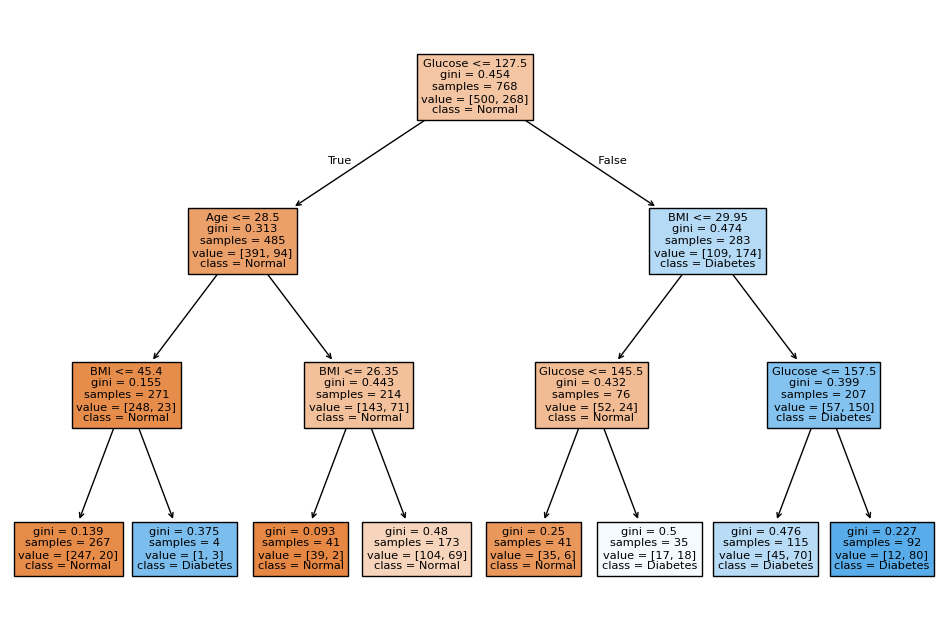

In [14]:
# 4 i.

clf = tree.DecisionTreeClassifier(max_depth=3, random_state=1)
clf.fit(X, y)

plt.figure(figsize=(12, 8))
tree.plot_tree(clf, feature_names=X.columns, class_names=['Normal', 'Diabetes'], filled=True)
plt.show()


### 4 ii.

After training the decision tree, you can interpret the tree to understand which features (e.g., glucose levels, BMI, age) are the most important in predicting diabetes.

Conditional Associations:

At each node, the decision tree will select a feature and a threshold for splitting the data. For example, a decision rule might be based on glucose level: "If glucose > 120, then higher chance of diabetes."
These thresholds characterize diabetes by showing which features and values are most predictive.
Posterior Probabilities:

Each leaf of the decision tree will output a probability distribution over the target classes (normal or diabetes).
For example, a leaf might indicate that among all patients reaching that node, 80% have diabetes and 20% are normal. This gives a posterior probability of diabetes given the conditions defined by the path leading to the leaf.
